In [120]:
%load_ext autoreload
%autoreload 2

from itertools import chain
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_curve, auc

plt.style.use('seaborn-whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fpath = Path('../data/prepared_data.csv')

In [75]:
data = pd.read_csv(fpath, index_col=0).sort_values(by=['customer_id', 'transaction_month']).reset_index(drop=True)

print(data.shape)

data.head(10)

(66370, 4)


,customer_id,mccs,mccs_count,transaction_month
0,0001f322716470bf9bfc1708f06f00fc,"6011,6011,6011,6011,6011,6011,6011",7,2
1,0001f322716470bf9bfc1708f06f00fc,"6011,6011,6011,6011,6011,6011,6011",7,3
2,0001f322716470bf9bfc1708f06f00fc,"5541,6011,6011,6011,6011,6011,6011,6011,6011",9,4
3,0001f322716470bf9bfc1708f06f00fc,"5411,5411,5541,5912,6011,6011,6011,6011,6011",9,5
4,0001f322716470bf9bfc1708f06f00fc,"5411,5411,5411,5411,5499,5541,5541,5999,5999,6...",18,6
5,0001f322716470bf9bfc1708f06f00fc,"5411,5411,5541,5999,6011,6011,6011",7,7
6,0001f322716470bf9bfc1708f06f00fc,"5411,5411,6011,6011,6011,6011,6011",7,8
7,0001f322716470bf9bfc1708f06f00fc,"5211,5411,5541,6011,6011,6011,6011,6011,6011,6...",11,9
8,0007297d86e14bd68bd87b1dbdefe302,"6011,6011,6011,6011,6011,6011",6,2
9,0007297d86e14bd68bd87b1dbdefe302,"6011,6011,6011,6011,6011,6011",6,3


In [76]:
months = sorted(data['transaction_month'].unique().tolist())
n_months = len(months)
month2id = dict(zip(months, range(n_months)))

months

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [77]:
customers = data['customer_id'].unique().tolist()
n_customers = len(customers)
customer2id = dict(zip(customers, range(n_customers)))

n_customers

9988

Распределение количества месяцев по пользователям.

In [78]:
data['customer_id'].value_counts().value_counts()

8    4362
6    1554
7    1309
5     846
4     616
9     478
3     452
2     264
1     107
Name: customer_id, dtype: int64

В столбце `mccs` в `data` записан список всех категорий товаров, приобретённых в данном месяце, разделённых запятой.

In [79]:
data['mccs'] = data['mccs'].apply(lambda x: x.split(','))
data.head()

,customer_id,mccs,mccs_count,transaction_month
0,0001f322716470bf9bfc1708f06f00fc,"[6011, 6011, 6011, 6011, 6011, 6011, 6011]",7,2
1,0001f322716470bf9bfc1708f06f00fc,"[6011, 6011, 6011, 6011, 6011, 6011, 6011]",7,3
2,0001f322716470bf9bfc1708f06f00fc,"[5541, 6011, 6011, 6011, 6011, 6011, 6011, 601...",9,4
3,0001f322716470bf9bfc1708f06f00fc,"[5411, 5411, 5541, 5912, 6011, 6011, 6011, 601...",9,5
4,0001f322716470bf9bfc1708f06f00fc,"[5411, 5411, 5411, 5411, 5499, 5541, 5541, 599...",18,6


In [80]:
pd.Series(chain.from_iterable(data['mccs'])).value_counts().head(15)

5411    340858
6011    227933
5814    111577
5812     53956
5499     38828
5541     36712
5912     35104
4111     21302
5921     15893
5331     11427
5691      9998
5261      9526
5977      8839
5311      8529
5999      8258
dtype: int64

In [81]:
mccs = sorted(set(chain.from_iterable(data['mccs'])))
n_mccs = len(mccs)
mcc2id = dict(zip(mccs, range(n_mccs)))

n_mccs

243

Массив с данными: `values[i, j, k]` - число транзакций `i`-го клиента в `j`-м месяце по `k`-му MCC-коду.

In [82]:
values = np.zeros((n_customers, n_months, n_mccs))

for _, row in tqdm(data.iterrows(), total=data.shape[0]):
    customer = row['customer_id']
    mccs_ = row['mccs']
    month = row['transaction_month']
    
    cid = customer2id[customer]
    mid = month2id[month]
    
    for mcc in mccs_:
        mccid = mcc2id[mcc]
        
        values[cid, mid, mccid] += 1

In [103]:
values[0, [2, 3, 4], :].sum(axis=1)

array([7., 9., 9.])

In [106]:
def get_data(months: list) -> tuple:
    month_ids = [month2id[month] for month in months]
    
    x = []
    y = []
    
    for row in values[:, month_ids, :]:
        if (row.sum(axis=1) > 0).all():  # at least one transaction each month
            x.append(row[:-1, :])
            y.append(row[-1, :])

    return x, y

In [107]:
n_months = 5

x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(months) - n_months + 1):
    months_ = months[i:i + n_months]
    
    x, y = get_data(months=months_)
    
    if months_[-1] == 9:
        x_test.extend(x)
        y_test.extend(y)
    
    else:
        x_train.extend(x)
        y_train.extend(y)
        
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(18772, 4, 243) (18772, 243)
(7010, 4, 243) (7010, 243)


In [111]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=x_train[0].shape),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_mccs, activation='sigmoid'),
])

In [112]:
model.compile(
    optimizer='adam',
    loss='mse',
)

In [113]:
model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_test, y_test),
)

Train on 18772 samples, validate on 7010 samples
Epoch 1/10
18772/18772 [==============================] - 3s 184us/sample - loss: 0.9570 - val_loss: 0.7872
Epoch 2/10
18772/18772 [==============================] - 2s 129us/sample - loss: 0.9441 - val_loss: 0.7855
Epoch 3/10
18772/18772 [==============================] - 2s 129us/sample - loss: 0.9427 - val_loss: 0.7848
Epoch 4/10
18772/18772 [==============================] - 2s 129us/sample - loss: 0.9418 - val_loss: 0.7845
Epoch 5/10
18772/18772 [==============================] - 2s 129us/sample - loss: 0.9412 - val_loss: 0.7841
Epoch 6/10
18772/18772 [==============================] - 2s 129us/sample - loss: 0.9408 - val_loss: 0.7842
Epoch 7/10
18772/18772 [==============================] - 2s 129us/sample - loss: 0.9403 - val_loss: 0.7840
Epoch 8/10
18772/18772 [==============================] - 2s 129us/sample - loss: 0.9400 - val_loss: 0.7840
Epoch 9/10
18772/18772 [==============================] - 2s 133us/sample - loss: 0.939

In [114]:
y_pred = model.predict(x_test)
y_pred.shape

(7010, 243)

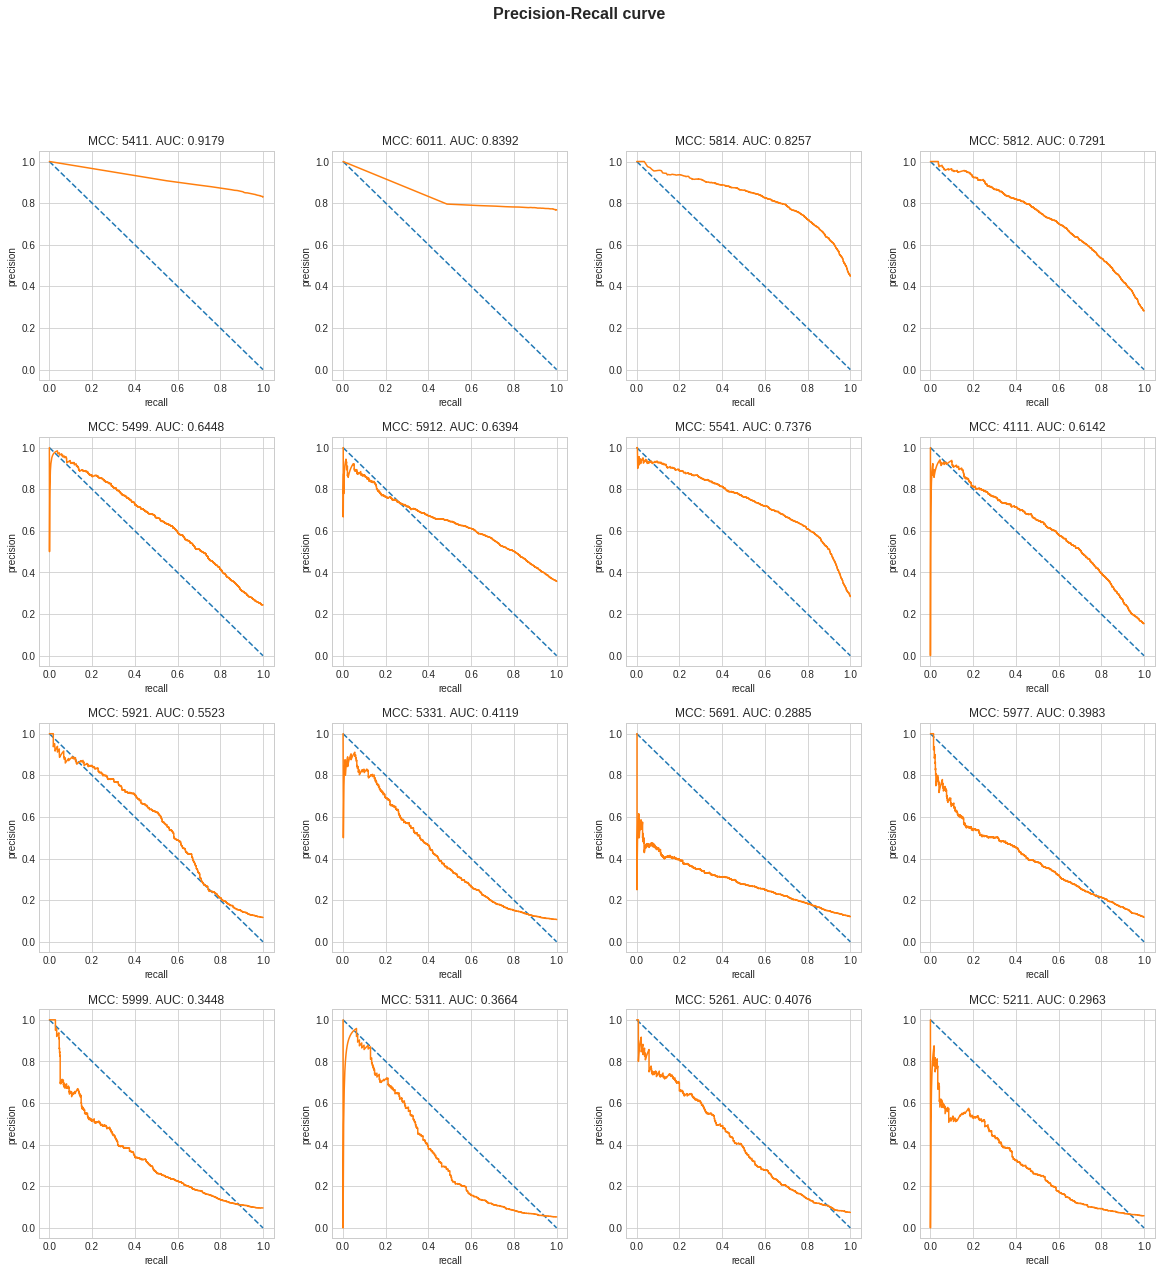

In [121]:
fig, axes = plt.subplots(nrows=4, ncols=4)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
fig.set_size_inches(20, 20)
axes = axes.flatten()

fig.suptitle('Precision-Recall curve', fontsize=16, fontweight='bold')

for mid, ax in zip(y_test.sum(axis=0).argsort()[::-1], axes):
    mcc = mccs[mid]

    x, y, _ = precision_recall_curve(y_test[:, mid] > 0, y_pred[:, mid])
    score = auc(y, x)

    ax.plot([0, 1], [1, 0], ls='dashed')
    ax.plot(y, x)

    ax.set_title(f'MCC: {mcc}. AUC: {round(score, 4)}')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')

In [116]:
def get_top5_mccs(probas: np.ndarray) -> set:
    top5_ids = probas.argsort()[-5:]
    top5_ids = [id_ for id_ in top5_ids if probas[id_] > 0]
    top5_mccs = {mccs[id_] for id_ in top5_ids}
    
    return top5_mccs

In [117]:
def jaccard(set1: set, set2: set) -> float:
    return len(set.intersection(set1, set2)) / len(set.union(set1, set2))

In [118]:
y_test_top5 = [get_top5_mccs(vector) for vector in y_test]
y_pred_top5 = [get_top5_mccs(vector) for vector in y_pred]

Text(0, 0.5, 'probability')

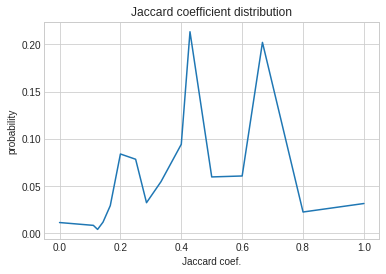

In [122]:
jac = [jaccard(s1, s2) for s1, s2 in zip(y_test_top5, y_pred_top5)]
jac = pd.Series(jac).value_counts().sort_index()
jac = jac / jac.sum()

plt.plot(jac)
plt.title('Jaccard coefficient distribution')
plt.xlabel('Jaccard coef.')
plt.ylabel('probability')